# Analyzing NYC High School Data

## Introduction

This is the 5th DataQuest project in Step 2: Data Analysis and Visualization. This is the 7th DataQuest project I have done overall.

In this project I will be analyzing New York City (NYC) High School Data pertaining to Scholastic Aptitude Test (SAT), demographics, and school characterics in order to gain some insight into factors that relate to SAT test scores.

There are 6 datasets relating to: AP Score, Class Size, Demographics, Graduation Rates, Highschool directory information, and SAT results.

## Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

## Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

## Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

## Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

## Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

## Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

## Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

## Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

## Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

## Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

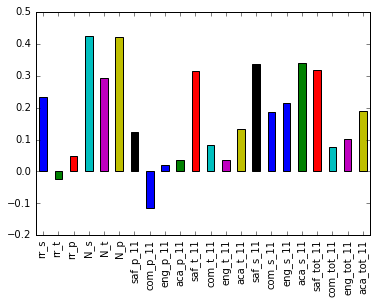

In [11]:
%matplotlib inline
combined.corr()["sat_score"][survey_fields].plot.bar()

In [12]:
combined.corr()["sat_score"][survey_fields].sort_values(ascending=False).head(5)

N_s           0.423463
N_p           0.421530
aca_s_11      0.339435
saf_s_11      0.337639
saf_tot_11    0.318753
Name: sat_score, dtype: float64

In [13]:
combined.corr()["sat_score"][survey_fields].sort_values().head(5)

com_p_11   -0.115073
rr_t       -0.023386
eng_p_11    0.020254
aca_p_11    0.035155
eng_t_11    0.036906
Name: sat_score, dtype: float64

Here we find that the top 5 correlations with SAT Score from the "survey_field" are N_s, N_p, aca_s_11, saf_s_11, saf_tot_11. 

These represent:
- N_s: Number of Student respondents
- N_p: Number of Parent respondents
- aca_s_11: Academic expectations based on parent responses
- saf_s_11: Safety and Respect score based on teacher responses 
- saf_tot_11: Safety and Respect Total score

N_s and N_p is interesting but not surprising. Respondents to survey often have an interest in the information being collected, and in this case, are more likely to also have an interest in doing well in school.

Parental expectations and the link with SAT scores is non-surprising.

Safety and Respect scores are not surprising either as a safe environment supports proper learning. We will explore this area next, but first note that all negative correlations in the data were weak.

To explore both "Safety and Respect" scores, we will create scatter plots with the relevant SAT scores.

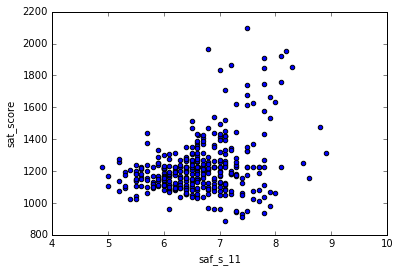

In [14]:
combined.plot.scatter(x="saf_s_11", y="sat_score")

The above plot shows teacher ratings for safety and respect against SAT scores. There seems to be a strong correlations for safety and respect scores from ~5 to ~7. This is especially strong below 6.5. After ~7, the correlation drops off.

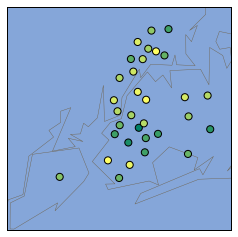

In [15]:
districts = combined.groupby("school_dist").agg(numpy.mean).copy()
districts.reset_index(inplace=True)

from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts["lon"].tolist()

latitudes = districts["lat"].tolist()

m.scatter(longitudes, latitudes, s=50, zorder=2,
          latlon=True, c=districts["saf_s_11"], cmap="summer")

In the above plot, highschools were grouped by district and their "Safety and Respect" scores, as marked by teachers, was averaged, along with the SAT scores for schools within that district.

The graph demonstrates that schools located in Manhanttan having higher "Safety and Respect" scores, with those in Brooklyn having the lowest.

Next, I'll examine the correlation of SAT scores among the different demographics of: whites, asians, blacks, and hispanics.

## Race and SAT Scores

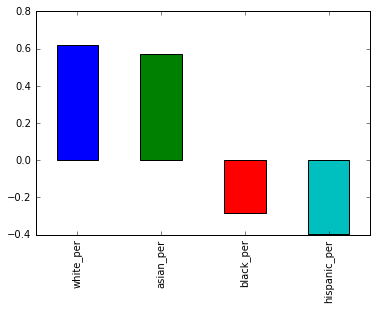

In [16]:
combined.corr()["sat_score"][["white_per", "asian_per", "black_per", "hispanic_per"]].plot.bar()

The plot indicates there is a negative correlation between SAT scores and the percentage of hispanic students. We can explore this further with a scatter plot of the schools, plotting percentage of hispanic students by scores.

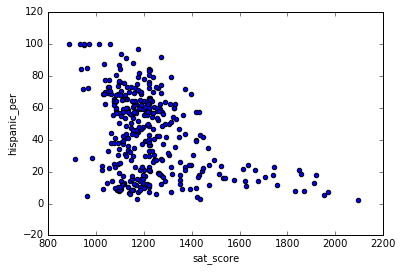

In [17]:
combined.plot.scatter(x="sat_score", y="hispanic_per")

There is an interesting trend in the chart. Once the percentage of hispanic students is below 30%, there is a spread in all the scores, and this seems to be driving the correlation score. Whenver there is a percentage of hispanic students above 30%, the SAT scores never go above 1500 points.

Now I'll examine the schools with the highest hispanic percentages:

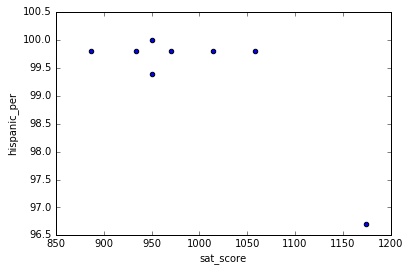

In [18]:
high_hisp_per = combined[combined["hispanic_per"] > 95].copy()

high_hisp_per.plot.scatter(x="sat_score", y="hispanic_per")

In [19]:
high_hisp_per.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
44,02M542,MANHATTAN BRIDGES HIGH SCHOOL,66,336.0,378.0,344.0,1058.0,Manhattan Bridges High School,67.000000,102.000000,...,0,0,0,0,0,0,"525 West 50Th Street\nNew York, NY 10019\n(40....",40.765027,-73.992517,02
82,06M348,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,70,380.0,395.0,399.0,1174.0,0,129.028846,197.038462,...,Then to New York City residents,0,0,0,0,0,"511 West 182Nd Street\nNew York, NY 10033\n(40...",40.848879,-73.930807,06
89,06M552,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,56,339.0,349.0,326.0,1014.0,GREGORIO LUPERON HS SCI & MATH,88.000000,138.000000,...,0,0,0,0,0,0,"501 West 165Th\nNew York, NY 10032\n(40.838032...",40.838032,-73.938371,06
125,09X365,ACADEMY FOR LANGUAGE AND TECHNOLOGY,54,315.0,339.0,297.0,951.0,Academy for Language and Technology,20.000000,20.000000,...,0,0,0,0,0,0,"1700 Macombs Road\nBronx, NY 10453\n(40.849102...",40.849102,-73.916088,09
141,10X342,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,49,300.0,333.0,301.0,934.0,International School for Liberal Arts,55.000000,73.000000,...,0,0,0,0,0,0,"2780 Reservoir Avenue\nBronx, NY 10468\n(40.87...",40.870377,-73.898163,10


A quick research of these schools indicates they they're focused on recent immigrants, and so it's likely most of the student population is learning English as a second language. This can be a reason for the low SAT scores.

In [20]:
(combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]).head()


,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
37,02M475,STUYVESANT HIGH SCHOOL,832,679.0,735.0,682.0,2096.0,STUYVESANT HS,1510.0,2819.0,...,0,0,0,0,0,0,"345 Chambers Street\nNew York, NY 10282\n(40.7...",40.717746,-74.014049,02
151,10X445,BRONX HIGH SCHOOL OF SCIENCE,731,632.0,688.0,649.0,1969.0,BRONX HS OF SCIENCE,1190.0,2435.0,...,0,0,0,0,0,0,"75 West 205 Street\nBronx, NY 10468\n(40.87705...",40.877056,-73.889780,10
187,13K430,BROOKLYN TECHNICAL HIGH SCHOOL,1277,587.0,659.0,587.0,1833.0,BROOKLYN TECHNICAL HS,2117.0,3692.0,...,0,0,0,0,0,0,"29 Ft Greene Place\nBrooklyn, NY 11217\n(40.68...",40.688107,-73.976745,13
327,28Q687,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,121,612.0,660.0,596.0,1868.0,Queens HS for Science York Colllege,215.0,338.0,...,0,0,0,0,0,0,"94-50 159 Street\nJamaica, NY 11433\n(40.70099...",40.700999,-73.798154,28
356,31R605,STATEN ISLAND TECHNICAL HIGH SCHOOL,227,635.0,682.0,636.0,1953.0,STATEN ISLAND TECHNICAL HS,528.0,905.0,...,0,0,0,0,0,0,"485 Clawson Street\nStaten Island, NY 10306\n(...",40.567913,-74.115362,31


A quick review of these schools indicates that most of them are geared towards Science and Technology and they also have entrance exams. 

Next, I'll examine gender.

## Gender and SAT Scores


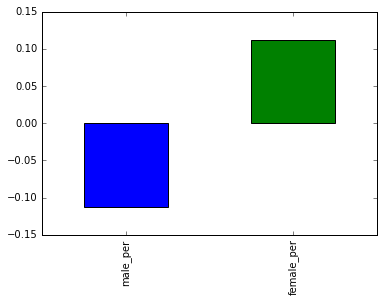

In [21]:
combined.corr()["sat_score"][["male_per", "female_per"]].plot.bar()

The plot above indicates that the higher the male population, the lower the average SAT score, and the higher the female population, the higher the average SAT score.

Now I'll make a scatter plot fermale student percentages against SAT scores.

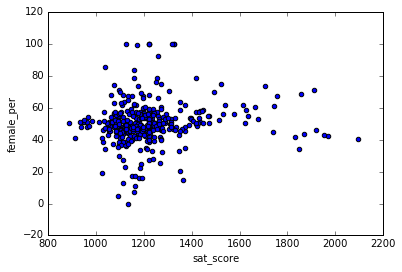

In [22]:
combined.plot.scatter(x="sat_score", y="female_per")

Interestingly, what tis plot shows is that schools with either low famle percentages (< 20), or high female percentages (> 80) do not have high SAT scores. In fact, the schools with the highest SAT scores have a female student percentages between 35-75 percent.

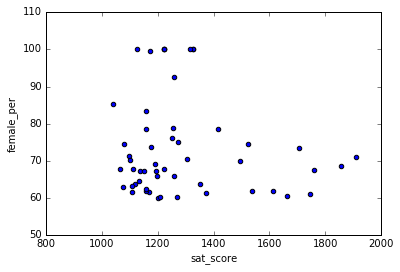

In [23]:
high_female_per = combined[combined["female_per"] > 60]

high_female_per.plot.scatter(x="sat_score", y="female_per")

In [24]:
high_female_per.sort_values(by="sat_score", ascending=False).head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
302,25Q525,TOWNSEND HARRIS HIGH SCHOOL,278,621.0,651.0,638.0,1910.0,TOWNSEND HARRIS HS,613.000000,796.000000,...,0,0,0,0,0,0,"149-11 Melbourne Avenue\nFlushing, NY 11367\n(...",40.734408,-73.821417,25
5,01M696,BARD HIGH SCHOOL EARLY COLLEGE,130,624.0,604.0,628.0,1856.0,0,129.028846,197.038462,...,0,0,0,0,0,0,"525 East Houston Street\nNew York, NY 10002\n(...",40.718962,-73.976066,01
26,02M416,ELEANOR ROOSEVELT HIGH SCHOOL,127,572.0,594.0,592.0,1758.0,Eleanor Roosevelt High School,155.000000,235.000000,...,0,0,0,0,0,0,"411 East 76 Street\nNew York, NY 10021\n(40.77...",40.770116,-73.953379,02
60,03M479,BEACON HIGH SCHOOL,261,577.0,575.0,592.0,1744.0,BEACON SCHOOL,166.000000,197.000000,...,0,0,0,0,0,0,"227-243 West 61St Street\nNew York, NY 10023\n...",40.772158,-73.987797,03
61,03M485,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,531,566.0,564.0,577.0,1707.0,FIORELLO H.LAGUARDIA HS,691.000000,1236.000000,...,0,0,0,0,0,0,"100 Amsterdam Avenue\nNew York, NY 10023\n(40....",40.773671,-73.985269,03


Now I'll examine the effect of the AP test on SAT scores.

## AP Tests and SAT Scores



In [25]:
# Find the percentage of AP test takers in each school
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]

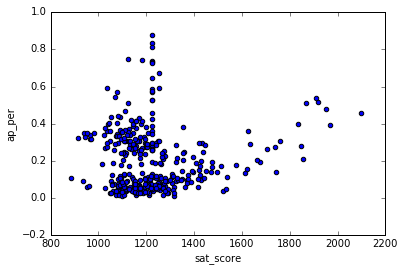

In [26]:
combined.plot.scatter(x="sat_score", y="ap_per")

There seemes to be two groups in the data set, an upper group and a lower group. The lower group demonstrates a weak correlation in the results.

However, in the upper group, there is a line at ~12,200, where multiple schools have the exact same SAT score. This is indicative of the way in which missing data was handled, by giving these schools the mean SAT score to fill in for their missing values. This seems to have a disturbing effect on the data and so it is difficult to determine what is going on in this situation.